In [82]:
import pandas as pd
from time import perf_counter as time
profiles = pd.read_pickle("data/profiles.pkl")

In [83]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Identificando o perfil de consumo dos otakus

*Usando um recorte aleatório de dados cedidos pela myanimelist.net.

## Overview dos perfis

Cerca de 57% das observações foram removidas por ausência de informações relevantes, mas ainda temos uma amostra de mais de 20 mil perfis de usuários!

Algumas das principais características deste público são:

### 66,5% são homens

In [84]:
# porcentagem de homens
profiles_amount = profiles.shape[0]
males_amount = (profiles["gender"] == "Male").sum()
males_percent = print("{:.1f}%".format(males_amount/profiles_amount *100))

66.5%


### A idade média é 29 anos

In [85]:
#idade media
average_age = print("{:.1f}".format(profiles["user_age"].mean()))

29.2


### O gênero mais popular é comédia

In [86]:
# Genero mais prevalente
anime_genres = [
    "Comedy", "Sports", "Drama", "School", "Shounen", "Music",
    "Romance", "Sci-Fi", "Adventure", "Mystery", "Fantasy", "Action",
    "Military", "Magic", "Supernatural", "Vampire", "Slice of Life",
    "Demons", "Historical", "Super Power", "Mecha", "Parody", "Samurai",
    "Seinen", "Police", "Psychological", "Josei", "Space", "Kids",
    "Shoujo Ai", "Ecchi", "Shoujo", "Horror", "Shounen Ai", "Cars",
    "Martial Arts", "Game", "Thriller", "Dementia", "Harem", "Hentai",
    "Yaoi", "Yuri"]
profiles[anime_genres].sum().idxmax()

'Comedy'

# Vamos nos aprofundar mais nos gêneros?

## Público alvo

Alguns gêneros de anime indicam o tipo de audiência para qual o anime é direcionado:

- **Shounen** para o público jovem e masculino;

- **Shoujo** para o público jovem e feminino;

- **Seinen** para o homens;

- **Josei** para o mulheres;

In [87]:
# configrando dataset
target_genres = ["Shounen", "Shoujo", "Seinen", "Josei"]

temp = profiles[target_genres].sum().reset_index()
temp.columns = ("Gênero", "Audiência")
temp["Audiência"] = temp["Audiência"]\
    .apply(lambda x: x/temp["Audiência"].sum() *100)
temp.sort_values(by="Audiência", inplace=True, ascending=False)

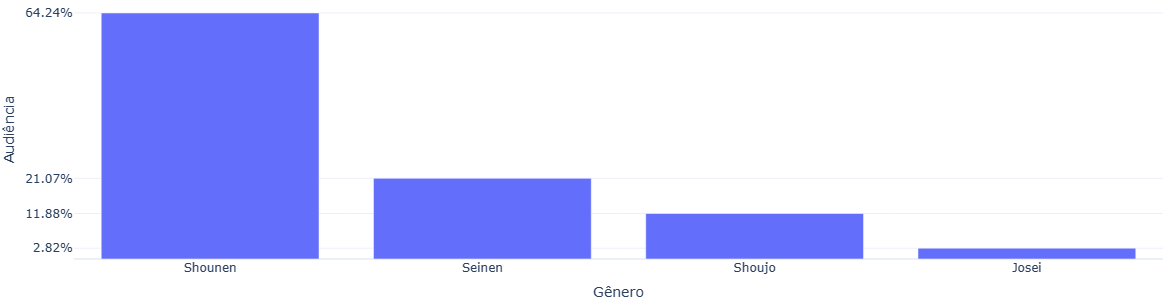

In [88]:
# configurando plot
fig = px.bar(temp, *temp.columns, template="plotly_white")
fig.update_yaxes(
    tickvals=temp["Audiência"], 
    ticktext=["{:.2f}%".format(x) for x in temp["Audiência"]]
)
fig.update_layout(height=300, width=900, margin={"t":0, "b":0, "l":0, "r":0})
fig.show(config={"displayModeBar": False})

## A audiência está compatível com o público alvo?

A maior parte do público se encaixa na categoria *Seinen*, aparentemente esta segregação de público-alvo **não tem sido muito efetiva** na prática já que o público é bastante nichado.

Outra coisa que chama bastante atenção é como a categoria *Shounen* tem tanta audiência, mesmo que todo o público que o assiste seja de outros públicos-alvo.

In [89]:
def check_target_audience(gender: str, age: int) -> list:
    underage = age < 18

    # Considerando apenas a idade para o publico nao-binario
    if gender in ["Female", "Male"]:
        if (gender == "Male") and underage:
            targeted_to = ["Shounen"]
        elif (gender == "Male") and not underage:
            targeted_to = ["Seinen"]
        elif (gender == "Female") and underage:
            targeted_to = ["Shoujo"]
        else:
            targeted_to = ["Josei"]
    else:
        if underage:
            targeted_to = ["Shounen", "Shoujo"]
        else:
            targeted_to = ["Seinen", "Josei"]
    
    return targeted_to

def is_target_to_genre(target: list, genre="Shounen"):
    return genre in target

def audience_by_target(target: list, Shounen: int, Seinen: int, Shoujo: int, Josei: int, return_on_target=True):
    
    if return_on_target:
        out = 0
        for i in target:
            match i:
                case "Shounen": 
                    out = out + Shounen
                case "Seinen": 
                    out = out + Seinen
                case "Shoujo": 
                    out = out + Shoujo
                case "Josei": 
                    out = out + Josei 
                case _: 
                    continue
    else:
        out = Shounen + Seinen + Shoujo + Josei
        for i in target:
            match i:
                case "Shounen": 
                    out = out - Shounen
                case "Seinen": 
                    out = out - Seinen
                case "Shoujo": 
                    out = out - Shoujo
                case "Josei": 
                    out = out - Josei
                case _: 
                    continue
    
    return out

In [90]:
profiles["targeted"] = profiles.apply(
    lambda x: check_target_audience(x.gender, x.user_age), axis=1
)

profiles["on_target"] = profiles.apply(
    lambda x: audience_by_target(
        x.targeted, x.Shounen, x.Seinen,
        x.Shoujo, x.Josei, return_on_target=True
    ), axis=1
)

profiles["off_target"] = profiles.apply(
    lambda x: audience_by_target(
        x.targeted, x.Shounen, x.Seinen,
        x.Shoujo, x.Josei, return_on_target=False
    ), axis=1
)

profiles["shounen_target"] = profiles["targeted"].apply(lambda x: is_target_to_genre(x, genre="Shounen"))
profiles["seinen_target"] = profiles["targeted"].apply(lambda x: is_target_to_genre(x, genre="Seinen"))
profiles["shoujo_target"] = profiles["targeted"].apply(lambda x: is_target_to_genre(x, genre="Shoujo"))
profiles["josei_target"] = profiles["targeted"].apply(lambda x: is_target_to_genre(x, genre="Josei"))

In [111]:
# configurando dados

# agregando informações de público alvo
targeted_audience = ["shounen_target", "seinen_target", "shoujo_target", "josei_target"]
temp = profiles\
    .groupby(by=targeted_audience)[target_genres]\
    .sum()\
    .reset_index()

# mapeando público-alvo aos respectivos gêneros em uma coluna
def is_target(genre: str, shounen: bool, seinen: bool, shoujo: bool, josei: bool) -> bool:
    match genre:
        case "Shounen": return shounen
        case "Seinen": return seinen
        case "Shoujo": return shoujo
        case "Josei": return josei
        case _: return False

temp = pd.melt(temp, id_vars=targeted_audience, var_name="Gênero", value_name="Audiência")
args = zip(temp.Gênero, temp.shounen_target, temp.seinen_target, temp.shoujo_target, temp.josei_target)
temp["Público-alvo"] = pd.Series([is_target(*x) for x in args]).map({True: "É público-alvo", False: "Não é público-alvo"})

# removendo colunas que não serão usadas
temp.drop(targeted_audience, axis="columns", inplace=True)

# agregando informações redundantes
temp = temp.groupby(["Gênero", "Público-alvo"]).sum().reset_index()

# valores em percentual e decrescentes
temp["Audiência"] = temp["Audiência"]\
    .apply(lambda x: x/temp["Audiência"].sum() *100)
temp.sort_values(by="Audiência", inplace=True, ascending=False)

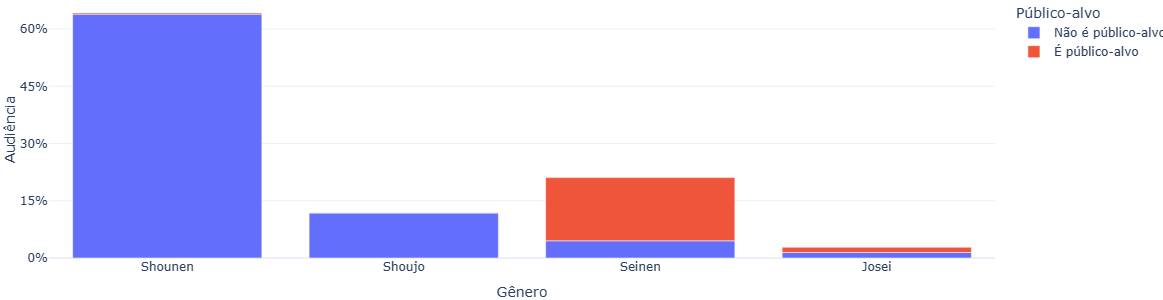

In [118]:
# configurando plot
fig = px.bar(
    temp, "Gênero", "Audiência", template="plotly_white", color="Público-alvo"
)

ticks = [x for x in range(0, 70, 15)]
fig.update_yaxes(
    tickvals=ticks, 
    ticktext=["{:.0f}%".format(x) for x in ticks]
)
fig.update_layout(height=400, width=900, margin={"t":0, "b":0, "l":0, "r":0})
fig.show(config={"displayModeBar": False})

## Quem assiste *shounen*?

kornos